In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

In [8]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

In [9]:
import os

data_dir = 'data'
exchange = 'test'

df_1m = pd.read_hdf(os.path.join(data_dir, exchange, 'all-pairs-1m-all.h5'))
df_1m

FileNotFoundError: File data/test/all-pairs-1m-all.h5 does not exist

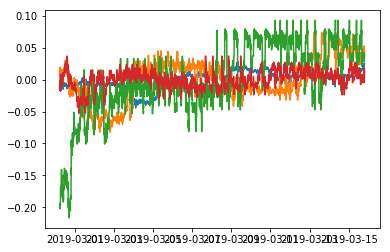

In [10]:
# df_5m = resample(df_1m, '5Min')
# df_5m
data = prep_data('data/data.p')
data_min = reduce_data(prep_data('data/data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

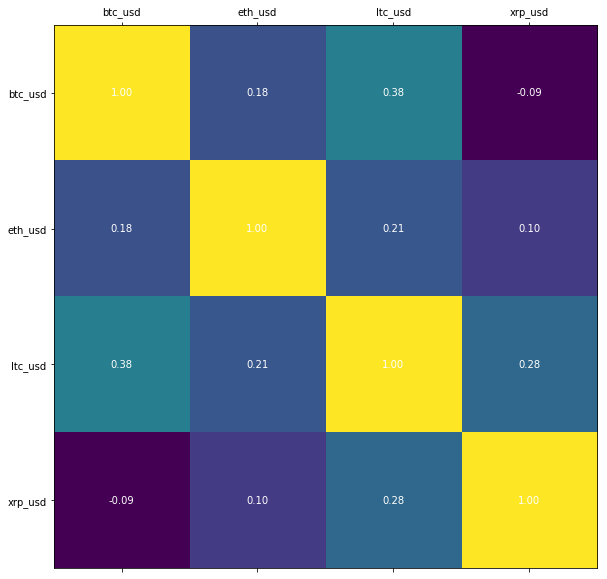

In [11]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [12]:
def cross_correlate_(x, y):
    return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

def cross_correlate(df):
    '''Compute cross-correlation matrix for the given dataframe.'''
    ccs = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i == j:
                ccs.loc[i,j] = 0
                continue
            if np.isnan(ccs.loc[i,j]):
                ccs.loc[i,j] = cross_correlate_(df[i], df[j])
                ccs.loc[j,i] = -ccs.loc[i,j]
    return ccs

print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
print(cross_correlate(data_min['prices']))

   0  1
0  0 -1
1  1  0
   0  1
0  0  0
1  0  0
         btc_usd  eth_usd  ltc_usd  xrp_usd
btc_usd        0        0        0        0
eth_usd        0        0        0        0
ltc_usd        0        0        0        0
xrp_usd        0        0        0        0


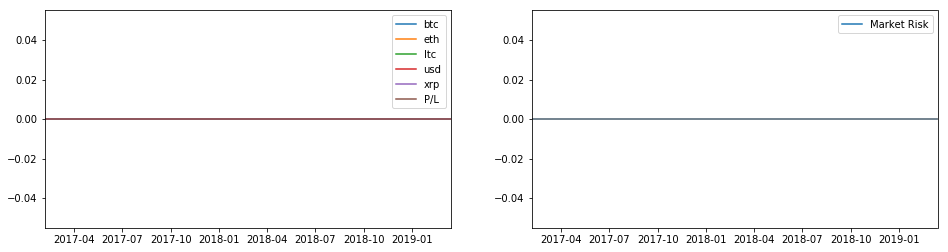

Return on maximum market risk: 0.0
Return on total market risk:   0.0
Return on total positions:     0.0
Sharpe ratio:                  0.0
Final P/L:                     0.0
Maximum absolute drawdown:     0
Maximum market risk:           0.0
Final balances:
usd    0.0
btc    0.0
eth    0.0
ltc    0.0
xrp    0.0
Name: 2019-03-14, dtype: float64


0.0

In [13]:
from strategy import HoldStrategy
from execution import run, analyze

analyze(run(HoldStrategy(), data))

In [ ]:
from strategy import KalmanFilterStrategy

analyze(run(KalmanFilterStrategy(correlation_window_size = 64, movement_half_life = 3), data_15min, fees=0.002))

In [14]:
from strategy import Strategy
from trader.util.stats import Ema, Gaussian

import numpy as np
import pandas as pd
from numpy_ringbuffer import RingBuffer


class KalmanFilter(Strategy):
    '''Predicts fairs based on correlated movements between pairs.
    All inputs should be cointegrated.'''

    def __init__(self, correlation_window_size, movement_half_life):
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.moving_prices = Ema(movement_half_life)
        self.moving_volumes = Ema(correlation_window_size)
        self.prev_prediction = None

    def step(self, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(
                self.correlation_window_size, dtype=(np.float, len(prices.index)))

        if self.prev_prediction is None:
            self.prev_prediction = self.null_estimate(prices)

        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return self.null_estimate(prices)

        self.moving_prices_history.append(self.moving_prices.value)

        if len(self.moving_prices_history) < self.correlation_window_size:
            return self.null_estimate(prices)

        df = pd.DataFrame(np.array(self.moving_prices_history), columns=prices.index)
        diffs = df.diff().iloc[1:]
        diff = Gaussian(diffs.iloc[-1], diffs.var())
        # Could also calculate diff from the raw price movements but using smoothed movements
        # for diff seems to improve RoR

        
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_delta_means = corr.mul(deltas, axis=0).mul(stddevs, axis=1).div(stddevs, axis=0)
        volume_signals = np.sqrt(self.moving_volumes.value * self.prev_prediction.mean)
        volume_factor = np.max(volume_signals) / volume_signals
        predicted_delta_variances = np.abs(df.cov().mul(stddevs, axis=1).div(stddevs, axis=0)) * volume_factor / (corr * corr)
        predicted_deltas = Gaussian.join([Gaussian(
            predicted_delta_means.loc[i], predicted_delta_variances.loc[i]) for i in prices.index])

        new_prediction = Gaussian.sum([self.prev_prediction, diff]) & (predicted_deltas + df.mean())
        self.prev_prediction = new_prediction
        return new_prediction

analyze(run(KalmanFilter(correlation_window_size = 64, movement_half_life = 1), data_15min, fees=0.002))

Gaussian(btc_usd    3820.981
eth_usd     135.050
ltc_usd      45.686
xrp_usd       0.310
Name: 2019-02-28 06:00:00, dtype: float64, [[1.e+100 0.e+000 0.e+000 0.e+000]
 [0.e+000 1.e+100 0.e+000 0.e+000]
 [0.e+000 0.e+000 1.e+100 0.e+000]
 [0.e+000 0.e+000 0.e+000 1.e+100]])
Gaussian(btc_usd    0.704456
eth_usd   -0.407311
ltc_usd    0.245077
xrp_usd    0.000279
Name: 63, dtype: float64, [[1.64100213e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.39332625e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.79629112e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.90051927e-07]])
Gaussian([3.80693080e+03 1.31869915e+02 5.12925599e+01 3.10648513e-01], [[7.29947627e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.90898965e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.76918959e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.62771468e-06]])
Gaussian(btc_usd    0.352228
et

Gaussian([3.81248138e+03 1.33302744e+02 5.09495028e+01 3.10587131e-01], [[1.14045081e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.56049657e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.23576653e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.86533324e-06]])
Gaussian(btc_usd    3.851845
eth_usd   -0.056622
ltc_usd    0.023060
xrp_usd   -0.000402
Name: 63, dtype: float64, [[1.03951661e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.53502509e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.80057668e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.28183324e-07]])
Gaussian([3.81604949e+03 1.33148887e+02 5.10242105e+01 3.10195654e-01], [[1.10269093e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.55236183e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.30648126e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

Gaussian([3.81131277e+03 1.31681201e+02 5.19614292e+01 3.06846219e-01], [[1.23779003e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.25734778e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.19162456e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.25420251e-06]])
Gaussian(btc_usd   -2.529555
eth_usd   -0.063259
ltc_usd    0.378175
xrp_usd   -0.000360
Name: 63, dtype: float64, [[8.99383318e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42517332e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.67987921e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.33316672e-07]])
Gaussian([3.80904781e+03 1.31717884e+02 5.23174022e+01 3.06424235e-01], [[1.22352375e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.07673491e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.22465658e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.16924609e-06]])
Gaussian(btc_usd    1.468975
eth_usd    0.222899
ltc_usd   -0.094997
xrp_usd   -0.000407
Name: 63, dtype: float64, [[6.97730051e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.73397908e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.69617707e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.23468048e-07]])
Gaussian([3.81675470e+03 1.30400671e+02 5.42868496e+01 3.02952246e-01], [[1.13305928e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.83747555e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.62833395e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.10223833e-06]])
Gaussian(btc_usd    6.034988
eth_usd   -0.181550
ltc_usd   -0.077499
xrp_usd   -0.000704
Name: 63, dtype: float64, [[7.37910247e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.72471193e-01 0.00000000e+00 0.00000000e+00]

Gaussian([3.82310908e+03 1.31375262e+02 5.33281414e+01 3.02606425e-01], [[1.83581763e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.06977490e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.30215993e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.73333181e-06]])
Gaussian(btc_usd    1.350989
eth_usd    1.750003
ltc_usd   -0.993249
xrp_usd   -0.000775
Name: 63, dtype: float64, [[8.02032611e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.41158502e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88638267e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.20419506e-06]])
Gaussian([3.82268885e+03 1.32615813e+02 5.24832872e+01 3.02389160e-01], [[1.85314218e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.81850950e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.48157736e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

Gaussian([3.81900187e+03 1.29698770e+02 5.46511500e+01 3.02361275e-01], [[1.45709524e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.90628906e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.92668382e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.34880625e-06]])
Gaussian(btc_usd    3.215592
eth_usd   -0.648194
ltc_usd    0.407034
xrp_usd    0.001267
Name: 63, dtype: float64, [[1.06314471e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.26760324e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.14814205e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.38149723e-06]])
Gaussian([3.82312436e+03 1.28969530e+02 5.48502671e+01 3.03883662e-01], [[1.42235631e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.87095734e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.95640779e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

Gaussian([3.82398554e+03 1.27331200e+02 5.51826866e+01 3.08840875e-01], [[1.62316830e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.45715141e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.97886942e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45321229e-06]])
Gaussian(btc_usd   -2.609632
eth_usd   -0.081944
ltc_usd    0.202331
xrp_usd    0.001866
Name: 63, dtype: float64, [[8.65958396e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.28456650e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.20675206e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.41499997e-06]])
Gaussian([3.82082381e+03 1.26997074e+02 5.53942687e+01 3.10755268e-01], [[1.64152600e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.45610530e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.94658999e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.96684058e-06]])
Gaussian(btc_usd   -5.016992
eth_usd    2.087919
ltc_usd   -1.301634
xrp_usd   -0.006811
Name: 63, dtype: float64, [[1.09313388e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.78061402e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.43784692e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.10692382e-06]])
Gaussian([3.80159740e+03 1.27949606e+02 5.39090322e+01 3.05501615e-01], [[2.13741667e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.67733188e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.20332714e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.33439383e-06]])
Gaussian(btc_usd   -0.348496
eth_usd    0.765960
ltc_usd   -0.621317
xrp_usd   -0.001906
Name: 63, dtype: float64, [[1.02435691e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.88594702e-01 0.00000000e+00 0.00000000e+00]

Gaussian([3.81168102e+03 1.26608884e+02 5.47375078e+01 3.10300505e-01], [[2.14256402e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.21641030e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.62832867e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.07024412e-06]])
Gaussian(btc_usd   -0.459512
eth_usd   -0.306477
ltc_usd    0.067285
xrp_usd   -0.000956
Name: 63, dtype: float64, [[1.18396245e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.45638137e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.73891225e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.42980348e-06]])
Gaussian([3.81009502e+03 1.26394480e+02 5.48036701e+01 3.09492896e-01], [[2.08948882e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.80756386e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.49973949e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.58685921e-06]])
Gaussian(btc_usd   -3.826499
eth_usd    0.080381
ltc_usd    0.652124
xrp_usd   -0.000568
Name: 63, dtype: float64, [[8.97597741e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.62824271e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.53754032e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.47612653e-06]])
Gaussian([3.8009082e+03 1.2532336e+02 5.6048680e+01 3.1253308e-01], [[1.75519637e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.06657846e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.30517483e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.47053385e-06]])
Gaussian(btc_usd    2.472751
eth_usd    0.235690
ltc_usd    0.826562
xrp_usd    0.000716
Name: 63, dtype: float64, [[9.08512562e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.63434975e-01 0.00000000e+00 0.00000000e+00]
 [0

KeyboardInterrupt: 

In [ ]:
from strategy import CointegratorStrategy

analyze(run(CointegratorStrategy(cointegration_window_size = 64), tail_data(data, 1000)))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 16), data_15min))

In [ ]:
analyze(run(KalmanFilterStrategy(
    correlation_window_size = 480,
    movement_half_life = 1
), tail_data(data_min, 10000), fees = 0.002))

In [ ]:
from strategy import CombinedStrategy

analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 60, movement_half_life = 3),
    CointegratorStrategy(cointegration_window_size = 16)
]), data_15min))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 512), data_5min))

In [ ]:
analyze(run(KalmanFilterStrategy(correlation_window_size = 165, movement_half_life = 70), data_5min))

In [ ]:
analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 16, movement_half_life = 8),
    CointegratorStrategy(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

Trying window_size: 452 and half_life: 7.37019970716923
  RoR: 31.39060004423915
Trying window_size: 594 and half_life: 3.2538479552507185
  RoR: 30.358317753522737
Trying window_size: 449 and half_life: 18.165556259211172
  RoR: 25.27887918172731
Trying window_size: 581 and half_life: 1.402374423326903
  RoR: 39.16131582429284
Trying window_size: 419 and half_life: 0.20585507935413005
  RoR: 23.881452752980703
Trying window_size: 468 and half_life: 4.51119467995318
  RoR: 32.55965289540743
Trying window_size: 685 and half_life: 27.419352928025482
  RoR: 13.875843371107885
Trying window_size: 639 and half_life: 9.025018837178589
  RoR: 22.39113027899303
Trying window_size: 444 and half_life: 0.7388083873556753
  RoR: 37.266145796668546
Trying window_size: 610 and half_life: 13.444000721160961
  RoR: 18.727460919910648
Trying window_size: 444 and half_life: 6.738442733405977
  RoR: 29.480422629388766
Trying window_size: 428 and half_life: 9.566359484274612
  RoR: 26.5222460389048
Trying

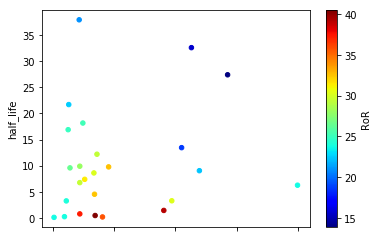

In [13]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 15
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 100) + 400
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        ror = analyze(run(KalmanFilterStrategy(window_size, movement_half_life), data, fees = 0.002), plot=False)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_min, 1500), 25)